# Imports:

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import time
from scipy import signal
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import torch
#from torch import nn
from sklearn.metrics import classification_report
from contextlib import redirect_stdout, redirect_stderr
import io
import pickle
import time
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from torchsummary import summary
#import torchinfo
#import moabb

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *            # Imports every needed algorithm such as CNN, RNN, LSTM, etc.
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy



# ATCNet Model imports
import models

In [4]:
# projects/def-b09sdp/bijan/Phase2/P16.fdt
path = !pwd
path

['/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI']

# Functions:

In [5]:
def data_wrapper(data_epochs, data_labels, mode='binary'):
    
    if mode == 'binary':
        epochs = []
        labels = []

        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            binary_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2)]
            #class2_epochs = participant_epochs[participant_labels==2]
            #bi_epochs = np.concatenate((class1_epochs, class2_epochs), axis=0)
            epochs.append(binary_epochs)
    
            binary_labels = participant_labels[(participant_labels==1) | (participant_labels==2)]
            #bi_labels = np.concatenate((class1_labels, class2_labels), axis=0)
            labels.append(binary_labels)
            
    elif mode == '3_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            labels.append(multiclass_labels)
            
            
    elif mode == '4_class_RS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
        
    elif mode == '4_class_LS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
    elif mode == '6_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            labels.append(multiclass_labels)
    
    return epochs, labels

In [6]:
def epoch_label_extractor(Data, epoch_length=1123, num_channels=64):
    df = Data.to_data_frame()
    X = df[df.columns[3:]].to_numpy()
    X = np.transpose(X)

    number_of_epochs = int(len(df)/epoch_length)
    
    randomlist = random.sample(range(number_of_epochs), number_of_epochs)

    data = np.zeros((number_of_epochs,num_channels, epoch_length))
    labels = np.zeros((number_of_epochs,1)).astype(int)

    for i in range(number_of_epochs):
        data[i,:,:] = X[:, randomlist[i]*epoch_length:(randomlist[i] + 1)*epoch_length]
        if (df['condition'][randomlist[i]*epoch_length] == 'Left'):
            labels[i,0] = 0
        elif(df['condition'][randomlist[i]*epoch_length] == 'Right'):
            labels[i,0] = 1
        elif(df['condition'][randomlist[i]*epoch_length] == 'Feet'):
            labels[i,0] = 2
        elif(df['condition'][randomlist[i]*epoch_length] == 'Tongue'):
            labels[i,0] = 3
        elif(df['condition'][randomlist[i]*epoch_length] == 'Mis'):
            labels[i,0] = 4
        elif(df['condition'][randomlist[i]*epoch_length] == 'Si'):
            labels[i,0] = 5
        else:
            labels[i,0] = 6
        
    return data, labels


In [7]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [8]:
def class_extraction(Classes, data, labels):
    mask = np.isin(labels[:, 0], Classes)
    dataset = data[mask, :, :]
    Final_labels = labels[mask, :]
    return dataset, Final_labels

In [9]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [10]:
def calc_csp(x_train, y_train, x_test, n_components=16):
    
        csp = CSP(n_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [11]:
def feature_extraction_4(dataset, labels, test_data, sampling_freq):

    # Why number of bands were set to 24??
    
    low_cutoff = 0
    number_of_bands = 8
    for b in range(number_of_bands):
        data = dataset.copy()
        data_test = test_data.copy()
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        filtered_data_test = mne.filter.filter_data(data_test, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, labels[:, 0], filtered_data_test)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 4
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [12]:
def feature_extraction_cheby2(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(15, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [13]:
def Preprocess_validator(train_data, train_labels, test_data, sampling_freq, n_components=2):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(40, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features, filtered_data.reshape((n_epochs_train, n_split, n_channels, n_samples))

# Device (GPU\CPU\MPS)

In [14]:

if tf.config.list_physical_devices('GPU'):
    device = "cuda"
else:
    # Check if TensorFlow Multi-Process Service (MPS) is available
    if tf.config.experimental.list_physical_devices('MPS'):
        device = "mps"
    else:
        device = "cpu"

print(f"Using {device} device")


Using cuda device


# ATCNet Model:

In [15]:
def getModel(model_name, dataset_conf):
    
    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://doi.org/10.1109/TII.2022.3197419
        model = models.ATCNet_( 
            # Dataset parameters
            n_classes = n_classes, 
            in_chans = n_channels, 
            in_samples = in_samples, 
            # Sliding window (SW) parameter
            n_windows = 5, 
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2, 
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2, 
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3, 
            tcn_activation='elu'
            )     
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)      
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)          
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples) 
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

In [16]:
dataset = 'BCI2a'
in_samples = 1000                   # Changed!!!
n_channels = 22
n_sub = 9
n_classes = 4
classes_labels = ['Left hand', 'Right hand','Foot','Tongue']



# Set dataset paramters as dataset configuration
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'isStandard': True, 'LOSO': True}


# Set training hyperparamters as train configuration
train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
              'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

model = getModel(train_conf.get('model'), dataset_conf)
    

2024-05-09 12:42:42.001538: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 12:42:44.560314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13625 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-05-09 12:42:44.563023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13625 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:5f:00.0, compute capability: 7.5
2024-05-09 12:42:44.565250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 1362

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 22, 1000  0           []                               
                                )]                                                                
                                                                                                  
 permute (Permute)              (None, 1000, 22, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 1000, 22, 16  1024        ['permute[0][0]']                
                                )                                                                 
                                                                                              

# Data reading:

In [18]:
path[0]

'/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI'

In [19]:
raw_data_path = "D:\Hadi_BCI\Recordings\Phase 1\PreProcessedData"

try: 
    if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
        print("Running on cloud ...")
        print("Please make sure to modify how you read the data according to your need!\n\n")
        raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase1"
            

except NameError:
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:\Hadi_BCI\Recordings\Phase 1\PreProcessedData"
    
    

all_data_epochs = []
all_data_labels = []

for participant_id in range(1, 16):
    if participant_id == 1:
        continue
    participant = f"P{participant_id}.set"

    file_path = f"{raw_data_path}/{participant}"

    raw_data = mne.read_epochs_eeglab(file_path)
    
    
    epochs, labels = epoch_label_extractor(raw_data, epoch_length=1123, num_channels=64)
    
    class_1=0
    class_2=1 
    class_3=2 
    class_4=3
    class_5=6
    
    num_channels = 64
    epoch_length = 1123
    
    data_epochs, data_labels = class_extraction([class_1, class_2, class_3, class_4, class_5], epochs, labels)
    
    all_data_epochs.append(data_epochs)
    all_data_labels.append(data_labels)

Running on cloud ...
Please make sure to modify how you read the data according to your need!


Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P2.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P3.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)
/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Channel names are not unique, found duplicates for: {'FCz'}. Applying running numbers for duplicates.
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
488 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P4.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)
/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Channel names are not unique, found duplicates for: {'FCz'}. Applying running numbers for duplicates.
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
491 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P5.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
489 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P6.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
489 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P7.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P8.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P9.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P10.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P11.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P12.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P13.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
488 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P14.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P15.set...


/tmp/ipykernel_107638/296819655.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [20]:
raw_data.event_id

{'Left': 1, 'Right': 2, 'Feet': 3, 'Tongue': 4, 'Mis': 5, 'Si': 6, 'Rest': 7}

In [21]:
for i in range(len(all_data_epochs)):
    print("Subject {} train epochs:    ".format(i+1), all_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), all_data_labels[i].shape)
    #print("Subject {} test epochs:     ".format(i+1), test_data_epochs[i].shape, "    Subject {} test labels:     ".format(i+1), test_data_labels[i].shape)

Subject 1 train epochs:     (350, 64, 1123)     Subject 1 train labels:     (350, 1)
Subject 2 train epochs:     (348, 64, 1123)     Subject 2 train labels:     (348, 1)
Subject 3 train epochs:     (350, 64, 1123)     Subject 3 train labels:     (350, 1)
Subject 4 train epochs:     (349, 64, 1123)     Subject 4 train labels:     (349, 1)
Subject 5 train epochs:     (349, 64, 1123)     Subject 5 train labels:     (349, 1)
Subject 6 train epochs:     (350, 64, 1123)     Subject 6 train labels:     (350, 1)
Subject 7 train epochs:     (350, 64, 1123)     Subject 7 train labels:     (350, 1)
Subject 8 train epochs:     (200, 64, 1123)     Subject 8 train labels:     (200, 1)
Subject 9 train epochs:     (350, 64, 1123)     Subject 9 train labels:     (350, 1)
Subject 10 train epochs:     (350, 64, 1123)     Subject 10 train labels:     (350, 1)
Subject 11 train epochs:     (350, 64, 1123)     Subject 11 train labels:     (350, 1)
Subject 12 train epochs:     (349, 64, 1123)     Subject 12 t

In [22]:
for i in range(len(all_data_epochs)):
    all_data_epochs[i] = np.expand_dims(all_data_epochs[i], 1)
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

All data epoch shape (sub 0):     (350, 1, 64, 1123)     All label shape (sub 0):      (350, 1)
All data epoch shape (sub 1):     (348, 1, 64, 1123)     All label shape (sub 1):      (348, 1)
All data epoch shape (sub 2):     (350, 1, 64, 1123)     All label shape (sub 2):      (350, 1)
All data epoch shape (sub 3):     (349, 1, 64, 1123)     All label shape (sub 3):      (349, 1)
All data epoch shape (sub 4):     (349, 1, 64, 1123)     All label shape (sub 4):      (349, 1)
All data epoch shape (sub 5):     (350, 1, 64, 1123)     All label shape (sub 5):      (350, 1)
All data epoch shape (sub 6):     (350, 1, 64, 1123)     All label shape (sub 6):      (350, 1)
All data epoch shape (sub 7):     (200, 1, 64, 1123)     All label shape (sub 7):      (200, 1)
All data epoch shape (sub 8):     (350, 1, 64, 1123)     All label shape (sub 8):      (350, 1)
All data epoch shape (sub 9):     (350, 1, 64, 1123)     All label shape (sub 9):      (350, 1)
All data epoch shape (sub 10):     (350,

In [23]:
for i in range(len(all_data_epochs)):
    print("Subject {} train epochs:    ".format(i+1), all_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), all_data_labels[i].shape)
    #print("Subject {} test epochs:     ".format(i+1), test_data_epochs[i].shape, "    Subject {} test labels:     ".format(i+1), test_data_labels[i].shape)

Subject 1 train epochs:     (350, 1, 64, 1123)     Subject 1 train labels:     (350, 1)
Subject 2 train epochs:     (348, 1, 64, 1123)     Subject 2 train labels:     (348, 1)
Subject 3 train epochs:     (350, 1, 64, 1123)     Subject 3 train labels:     (350, 1)
Subject 4 train epochs:     (349, 1, 64, 1123)     Subject 4 train labels:     (349, 1)
Subject 5 train epochs:     (349, 1, 64, 1123)     Subject 5 train labels:     (349, 1)
Subject 6 train epochs:     (350, 1, 64, 1123)     Subject 6 train labels:     (350, 1)
Subject 7 train epochs:     (350, 1, 64, 1123)     Subject 7 train labels:     (350, 1)
Subject 8 train epochs:     (200, 1, 64, 1123)     Subject 8 train labels:     (200, 1)
Subject 9 train epochs:     (350, 1, 64, 1123)     Subject 9 train labels:     (350, 1)
Subject 10 train epochs:     (350, 1, 64, 1123)     Subject 10 train labels:     (350, 1)
Subject 11 train epochs:     (350, 1, 64, 1123)     Subject 11 train labels:     (350, 1)
Subject 12 train epochs:    

# Encoding

In [24]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [25]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[3].shape)
print("Participant 16 - labels[0] shape:", encoded[3].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[3][:5])

Epochs Length: 14
labels Length: 14



Participant 16 - Epochs[0] shape: (349, 1)
Participant 16 - labels[0] shape: (349, 5)



Participant 16 - labels[0]:
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


# Within Subject:

In [26]:
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500




for j in range(num_subjects):
    
    epochs_subject = all_data_epochs[j]
    labels_subject = encoded[j]
    labels_subject_no_encode = no_encode[j]
    
    print(labels_subject_no_encode.shape)
    
    kf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    tests_pred = []
    tests_true = []
    
    for i, (train_index, test_index) in enumerate(kf_outer2.split(epochs_subject, labels_subject_no_encode[:, 0])):



        train_epochs = np.array([epochs_subject[j] for j in train_index])
        test_epochs = np.array([epochs_subject[k] for k in test_index])
        train_labels = np.array([labels_subject[l] for l in train_index])
        test_labels = np.array([labels_subject[m] for m in test_index])
        no_encoded_train_labels = np.array([labels_subject_no_encode[n] for n in train_index])
        no_encoded_test_labels = np.array([labels_subject_no_encode[o] for o in test_index])
        


        print("Outer Loop {}".format(i+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)


        dataset = 'BCI2a'
        in_samples = 1123                   # Changed!!!
        n_channels = 64
        n_classes = 5


        # Set dataset paramters as dataset configuration
        dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels, 
                        'n_channels': n_channels, 'in_samples': in_samples}


        # Set training hyperparamters as train configuration
        train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
                      'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

        model = getModel(train_conf.get('model'), dataset_conf)


        model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=train_conf.get('lr')), metrics=['accuracy'])

        patience = 20
        train_loss_epochs = []
        train_acc_epochs = []
        test_loss_epochs = []
        test_acc_epochs = []
        train_conf_mat = []

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


        

        # Train the model
        history = model.fit(
            train_epochs, train_labels,
            validation_data=(test_epochs, test_labels),
            epochs=max_epochs,
            batch_size=64,  # Adjust as needed
            callbacks=[early_stopping]
        )

        y_pred_test = model.predict(test_epochs)
        y_true_test = test_labels

        

        # Collect training metrics
        train_loss_epochs.extend(history.history['loss'])
        train_acc_epochs.extend(history.history['accuracy'])

        # Collect testing metrics
        test_loss_epochs.extend(history.history['val_loss'])
        test_acc_epochs.extend(history.history['val_accuracy'])

        epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)

        plt.figure(figsize=(12, 6))
        plt.suptitle("Participant {} - Fold {} - Within Subject".format(j+1, i+1))

        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(epochs_range, train_loss_epochs[:-1*patience])
        plt.plot(epochs_range, test_loss_epochs[:-1*patience])
        plt.legend(["Train", "Test"])

        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(epochs_range, train_acc_epochs[:-1*patience])
        plt.plot(epochs_range, test_acc_epochs[:-1*patience])
        plt.legend(["Train", "Test"])
        plt.savefig("P{}_F{}_WS.jpg".format(j+1, i+1))
        #plt.show()
        plt.clf()
        
        tests_pred.extend(y_pred_test)
        tests_true.extend(y_true_test)
    
    with open("y_pred_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_pred, f)

    with open("y_true_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_true, f)
        
    all_tests_pred.append(tests_pred)
    all_tests_true.append(tests_true)


(350, 1)
Outer Loop 1 

      Train epochs' shape:                                (280, 1, 64, 1123)
      Test epochs' shape:                                 (70, 1, 64, 1123)
Epoch 1/500


2024-05-09 12:43:32.692460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-05-09 12:43:33.358939: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 12:43:33.361404: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 12:43:33.361540: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-09 12:43:33.363860: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 12:43:33.363990: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


5/5 [==============================] - 14s 495ms/step - loss: 28.6655 - accuracy: 0.2107 - val_loss: 25.5135 - val_accuracy: 0.2429
Epoch 2/500
5/5 [==============================] - 1s 127ms/step - loss: 25.3314 - accuracy: 0.2643 - val_loss: 24.6843 - val_accuracy: 0.3286
Epoch 3/500
5/5 [==============================] - 1s 126ms/step - loss: 24.3812 - accuracy: 0.3357 - val_loss: 23.8816 - val_accuracy: 0.3286
Epoch 4/500
5/5 [==============================] - 1s 126ms/step - loss: 23.4405 - accuracy: 0.4321 - val_loss: 23.0957 - val_accuracy: 0.3000
Epoch 5/500
5/5 [==============================] - 1s 131ms/step - loss: 22.6525 - accuracy: 0.4143 - val_loss: 22.3327 - val_accuracy: 0.3571
Epoch 6/500
5/5 [==============================] - 1s 131ms/step - loss: 21.7725 - accuracy: 0.5071 - val_loss: 21.5952 - val_accuracy: 0.3429
Epoch 7/500
5/5 [==============================] - 1s 119ms/step - loss: 21.0226 - accuracy: 0.4821 - val_loss: 20.8872 - val_accuracy: 0.3429
Epoch 8/50

/tmp/ipykernel_107638/3082603097.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


Outer Loop 2 

      Train epochs' shape:                                (279, 1, 64, 1123)
      Test epochs' shape:                                 (70, 1, 64, 1123)
Epoch 1/500
5/5 [==============================] - 11s 427ms/step - loss: 27.6997 - accuracy: 0.1864 - val_loss: 24.5124 - val_accuracy: 0.2000
Epoch 2/500
5/5 [==============================] - 1s 130ms/step - loss: 24.3582 - accuracy: 0.2294 - val_loss: 23.7211 - val_accuracy: 0.2571
Epoch 3/500
5/5 [==============================] - 1s 132ms/step - loss: 23.4711 - accuracy: 0.3118 - val_loss: 22.9520 - val_accuracy: 0.2286
Epoch 4/500
5/5 [==============================] - 1s 129ms/step - loss: 22.6213 - accuracy: 0.3513 - val_loss: 22.2019 - val_accuracy: 0.2143
Epoch 5/500
5/5 [==============================] - 1s 129ms/step - loss: 21.8508 - accuracy: 0.3943 - val_loss: 21.4760 - val_accuracy: 0.2143
Epoch 6/500
5/5 [==============================] - 1s 133ms/step - loss: 21.0456 - accuracy: 0.4516 - val_loss: 20.7

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [83]:
participants[0]

1

In [30]:
print(len(all_tests_pred))

9


In [31]:
print(np.concatenate(all_tests_pred[4]).shape)

(1160,)


In [27]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(1, 10):
    
    if i == 4:
        continue
    
    with open("y_pred_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
    


for j in range(len(all_y_true)):
    
    y_true = np.array(all_y_true[j])
    y_pred = np.array(all_y_pred[j])
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [28]:
len(confusion_matrices)

8

In [ ]:
confusion_matrices[3]

In [90]:
print(confusion_matrices[1])

[[44 14  9  5]
 [14 36 11 11]
 [ 5  3 60  4]
 [ 7  6  2 57]]


In [91]:
print(len(confusion_matrices))

9


In [29]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)', 'Rest (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)', 'Rest (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 5


In [30]:
print("Dataset: Hadi Phase-1 (5-Class)")
print("The within-subject scenario:")
print("Algorithm: ATCNet")
print("Accuracy: ", acc)

normalized

Dataset: Hadi Phase-1 (5-Class)
The within-subject scenario:
Algorithm: ATCNet
Accuracy:  0.555667880971141


Left (Pred)  Right (Pred)  Feet (Pred)  Tongue (Pred)  \
Left (True)       0.509470      0.166667     0.113636       0.102273   
Right (True)      0.105660      0.594340     0.113208       0.088679   
Feet (True)       0.077505      0.109641     0.500945       0.179584   
Tongue (True)     0.100000      0.081132     0.143396       0.539623   
Rest (True)       0.060377      0.073585     0.115094       0.116981   

               Rest (Pred)  
Left (True)       0.107955  
Right (True)      0.098113  
Feet (True)       0.132325  
Tongue (True)     0.135849  
Rest (True)       0.633962

In [31]:
summation.sum(axis=1)

Left (True)      528
Right (True)     530
Feet (True)      529
Tongue (True)    530
SI (True)        531
Rest (True)      530
dtype: int64

# Cross-subjects (WO hyperparameter tuning):

Outer Loop 1 

      Train epochs' shape:                                (4396, 1, 64, 1123)
      Test epochs' shape:                                 (349, 1, 64, 1123)
      Test labels' shape:                                 (349, 5)
      Train labels' shape (without encoding):             (4396, 1)
      Test labels' shape (without encoding):              (349, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14]
      Test index:                                         [12]



Epoch 1/500


2024-05-09 06:42:45.024676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-05-09 06:42:45.533786: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 06:42:45.536803: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 06:42:45.536926: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-09 06:42:45.541005: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 06:42:45.541141: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


69/69 [==============================] - 20s 130ms/step - loss: 19.9791 - accuracy: 0.2102 - val_loss: 15.3709 - val_accuracy: 0.2006
Epoch 2/500
69/69 [==============================] - 7s 104ms/step - loss: 12.4156 - accuracy: 0.2368 - val_loss: 9.7406 - val_accuracy: 0.2521
Epoch 3/500
69/69 [==============================] - 7s 104ms/step - loss: 7.8891 - accuracy: 0.2807 - val_loss: 6.3062 - val_accuracy: 0.2550
Epoch 4/500
69/69 [==============================] - 7s 104ms/step - loss: 5.1544 - accuracy: 0.3162 - val_loss: 4.2636 - val_accuracy: 0.2808
Epoch 5/500
69/69 [==============================] - 7s 105ms/step - loss: 3.5398 - accuracy: 0.3446 - val_loss: 3.0979 - val_accuracy: 0.2436
Epoch 6/500
69/69 [==============================] - 7s 104ms/step - loss: 2.6132 - accuracy: 0.3690 - val_loss: 2.3829 - val_accuracy: 0.4040
Epoch 7/500
69/69 [==============================] - 7s 105ms/step - loss: 2.1078 - accuracy: 0.3769 - val_loss: 2.0351 - val_accuracy: 0.3410
Epoch 8

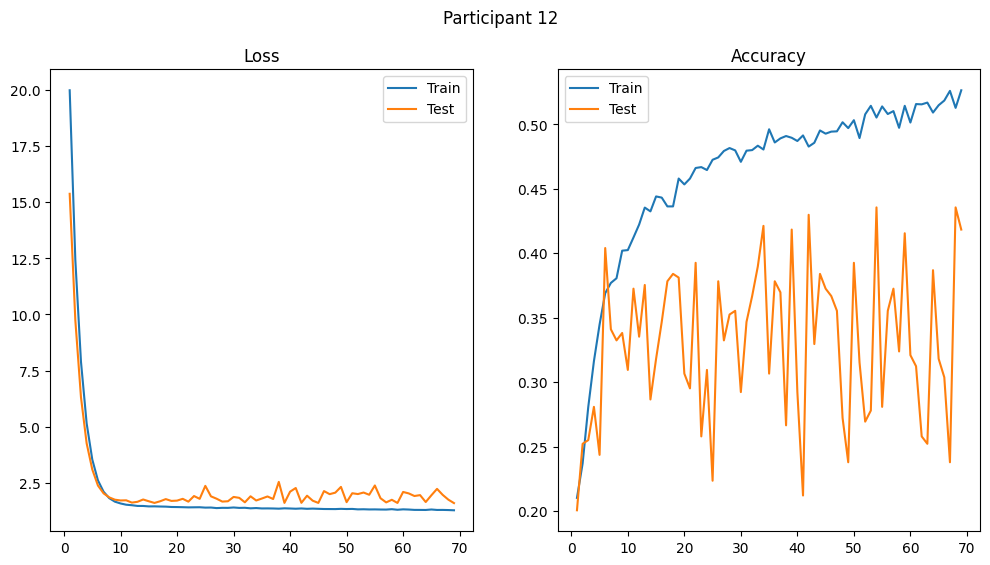

Outer Loop 2 

      Train epochs' shape:                                (4396, 1, 64, 1123)
      Test epochs' shape:                                 (349, 1, 64, 1123)
      Test labels' shape:                                 (349, 5)
      Train labels' shape (without encoding):             (4396, 1)
      Test labels' shape (without encoding):              (349, 1)
      Train index:                                        [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [5]



Epoch 1/500
69/69 [==============================] - 17s 122ms/step - loss: 19.9277 - accuracy: 0.2095 - val_loss: 15.3563 - val_accuracy: 0.2493
Epoch 2/500
69/69 [==============================] - 7s 104ms/step - loss: 12.4312 - accuracy: 0.2425 - val_loss: 9.7931 - val_accuracy: 0.2206
Epoch 3/500
69/69 [==============================] - 7s 105ms/step - loss: 7.9538 - accuracy: 0.2682 - val_loss: 6.4061 - val_accuracy: 0.2034
Epoch 4/500
69/69 [========

<Figure size 640x480 with 0 Axes>

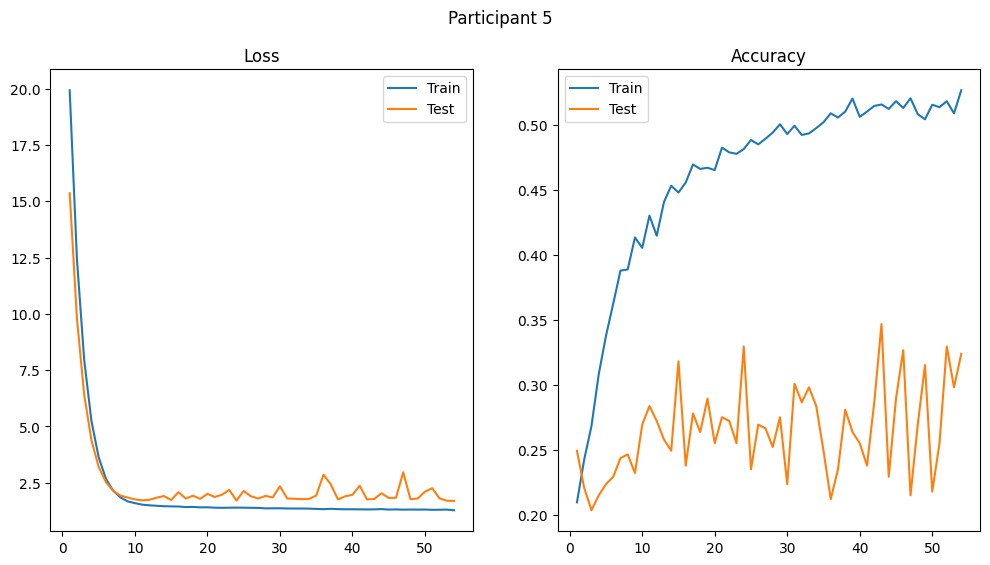

Outer Loop 3 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [6]



Epoch 1/500
69/69 [==============================] - 18s 131ms/step - loss: 21.8521 - accuracy: 0.2159 - val_loss: 16.9262 - val_accuracy: 0.2114
Epoch 2/500
69/69 [==============================] - 7s 105ms/step - loss: 13.6884 - accuracy: 0.2332 - val_loss: 10.7561 - val_accuracy: 0.2143
Epoch 3/500
69/69 [==============================] - 7s 105ms/step - loss: 8.7134 - accuracy: 0.2724 - val_loss: 6.9686 - val_accuracy: 0.2143
Epoch 4/500
69/69 [=======

<Figure size 640x480 with 0 Axes>

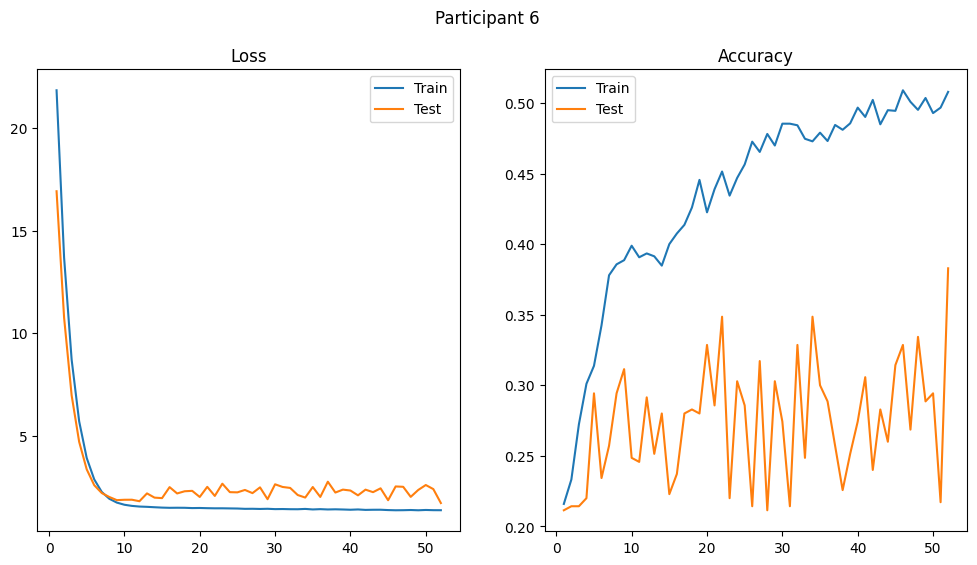

Outer Loop 4 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [1]



Epoch 1/500
69/69 [==============================] - 17s 122ms/step - loss: 20.4343 - accuracy: 0.2114 - val_loss: 15.7364 - val_accuracy: 0.2457
Epoch 2/500
69/69 [==============================] - 7s 103ms/step - loss: 12.7191 - accuracy: 0.2476 - val_loss: 9.9918 - val_accuracy: 0.2143
Epoch 3/500
69/69 [==============================] - 7s 104ms/step - loss: 8.1038 - accuracy: 0.2830 - val_loss: 6.4734 - val_accuracy: 0.2371
Epoch 4/500
69/69 [========

<Figure size 640x480 with 0 Axes>

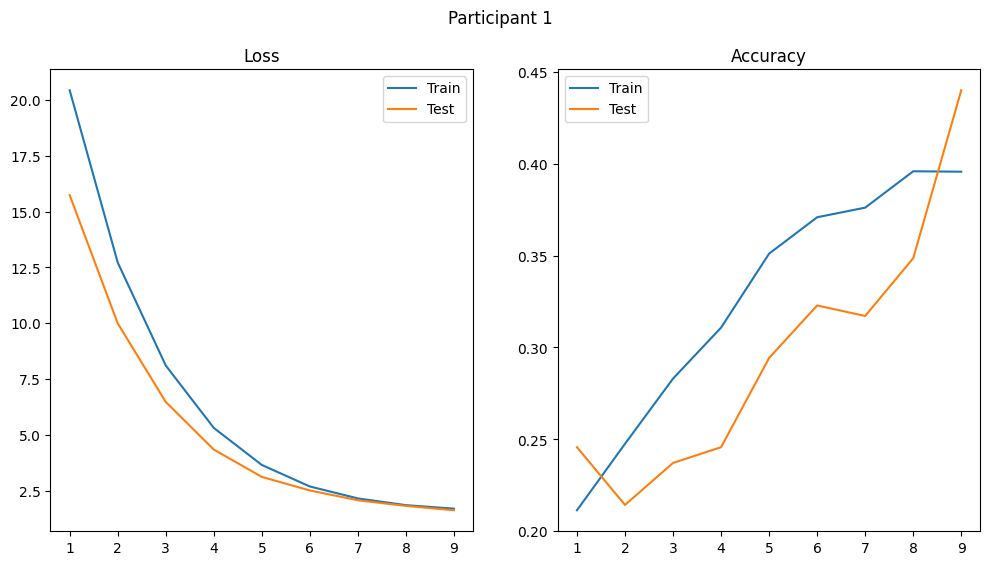

Outer Loop 5 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14]
      Test index:                                         [10]



Epoch 1/500
69/69 [==============================] - 17s 122ms/step - loss: 20.7918 - accuracy: 0.2059 - val_loss: 16.0808 - val_accuracy: 0.2114
Epoch 2/500
69/69 [==============================] - 7s 104ms/step - loss: 13.0056 - accuracy: 0.2457 - val_loss: 10.2569 - val_accuracy: 0.2257
Epoch 3/500
69/69 [==============================] - 7s 103ms/step - loss: 8.3149 - accuracy: 0.2771 - val_loss: 6.6902 - val_accuracy: 0.2514
Epoch 4/500
69/69 [=======

<Figure size 640x480 with 0 Axes>

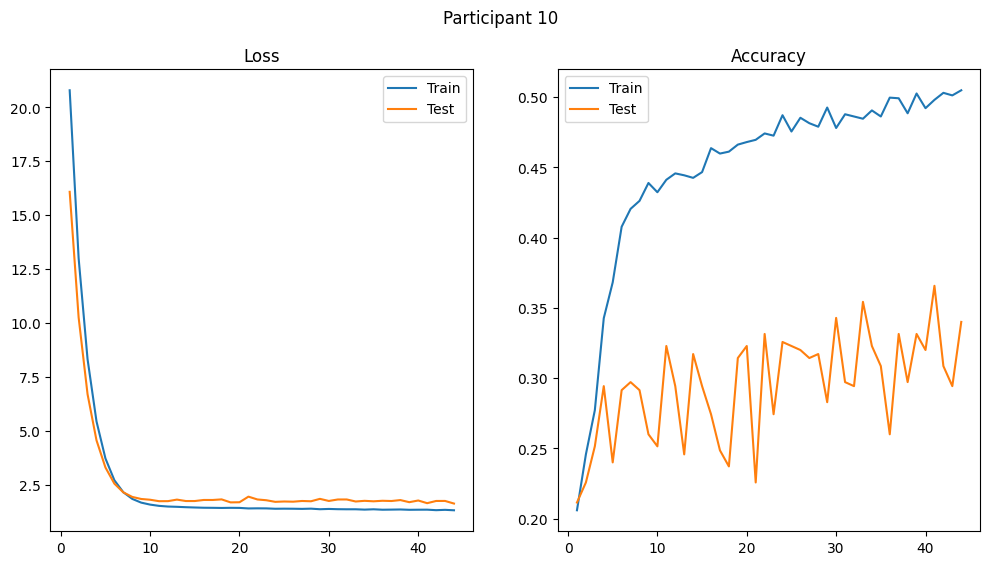

Outer Loop 6 

      Train epochs' shape:                                (4396, 1, 64, 1123)
      Test epochs' shape:                                 (349, 1, 64, 1123)
      Test labels' shape:                                 (349, 5)
      Train labels' shape (without encoding):             (4396, 1)
      Test labels' shape (without encoding):              (349, 1)
      Train index:                                        [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [4]



Epoch 1/500
69/69 [==============================] - 17s 122ms/step - loss: 20.3155 - accuracy: 0.2168 - val_loss: 15.6714 - val_accuracy: 0.2006
Epoch 2/500
69/69 [==============================] - 7s 103ms/step - loss: 12.6701 - accuracy: 0.2557 - val_loss: 9.9823 - val_accuracy: 0.2178
Epoch 3/500
69/69 [==============================] - 7s 104ms/step - loss: 8.0589 - accuracy: 0.3023 - val_loss: 6.4955 - val_accuracy: 0.2521
Epoch 4/500
69/69 [========

<Figure size 640x480 with 0 Axes>

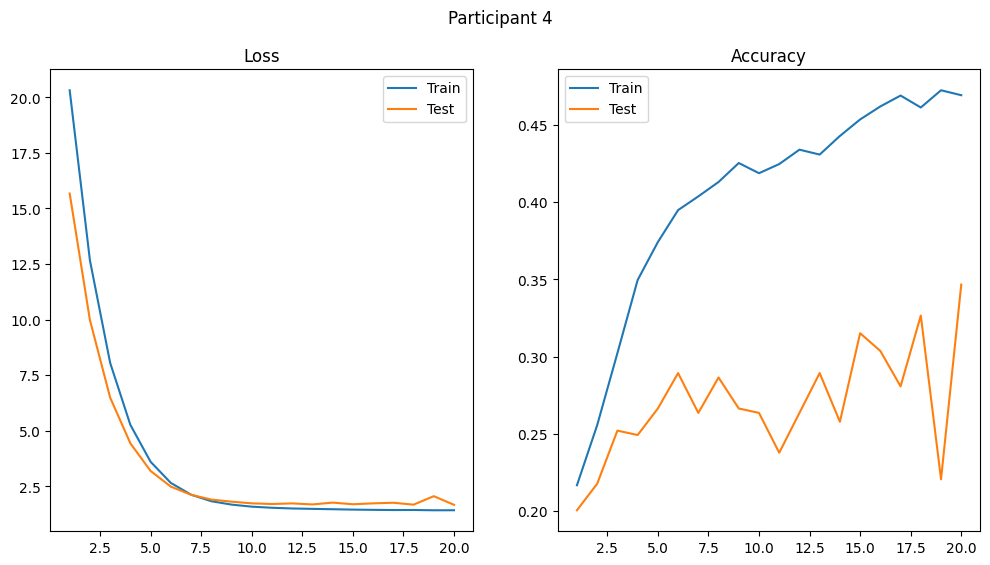

Outer Loop 7 

      Train epochs' shape:                                (4397, 1, 64, 1123)
      Test epochs' shape:                                 (348, 1, 64, 1123)
      Test labels' shape:                                 (348, 5)
      Train labels' shape (without encoding):             (4397, 1)
      Test labels' shape (without encoding):              (348, 1)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [2]



Epoch 1/500
69/69 [==============================] - 18s 131ms/step - loss: 19.4898 - accuracy: 0.2063 - val_loss: 14.9487 - val_accuracy: 0.2471
Epoch 2/500
69/69 [==============================] - 7s 102ms/step - loss: 12.0382 - accuracy: 0.2622 - val_loss: 9.4583 - val_accuracy: 0.2816
Epoch 3/500
69/69 [==============================] - 7s 103ms/step - loss: 7.6491 - accuracy: 0.2909 - val_loss: 6.1521 - val_accuracy: 0.2414
Epoch 4/500
69/69 [========

<Figure size 640x480 with 0 Axes>

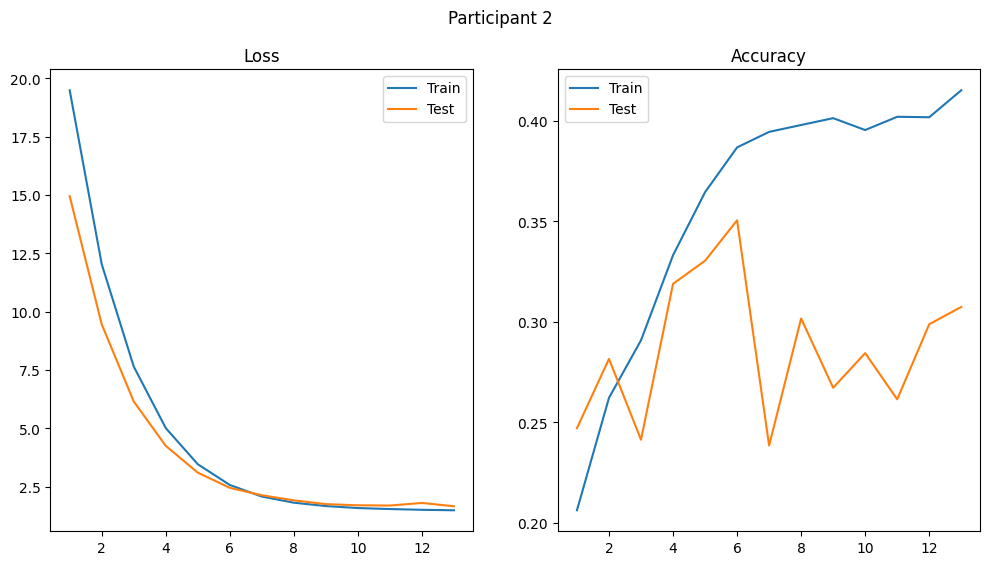

Outer Loop 8 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
      Test index:                                         [11]



Epoch 1/500
69/69 [==============================] - 17s 122ms/step - loss: 19.7448 - accuracy: 0.2041 - val_loss: 15.1889 - val_accuracy: 0.1914
Epoch 2/500
69/69 [==============================] - 7s 104ms/step - loss: 12.2608 - accuracy: 0.2457 - val_loss: 9.6368 - val_accuracy: 0.2343
Epoch 3/500
69/69 [==============================] - 7s 104ms/step - loss: 7.8160 - accuracy: 0.2815 - val_loss: 6.2771 - val_accuracy: 0.2400
Epoch 4/500
69/69 [========

<Figure size 640x480 with 0 Axes>

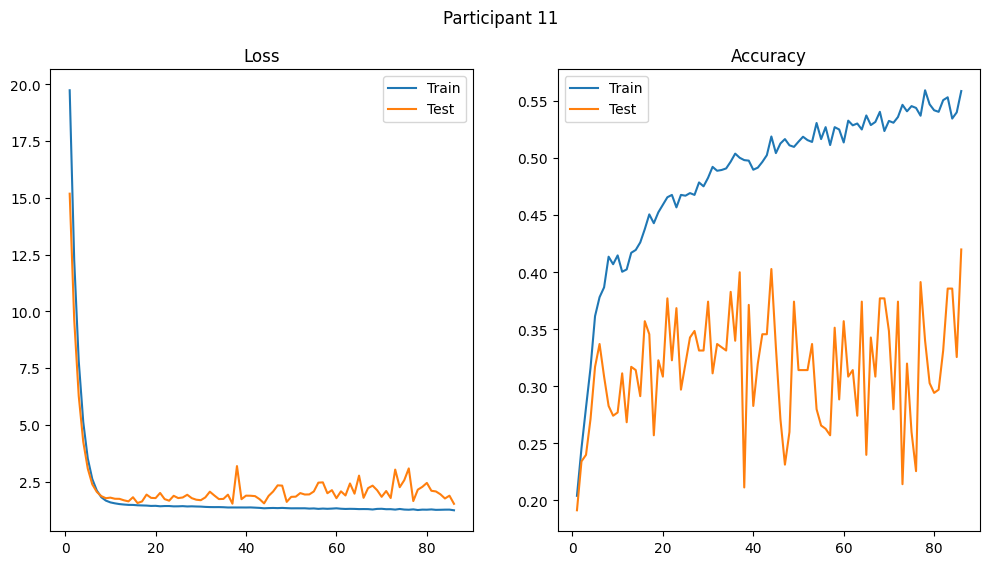

Outer Loop 9 

      Train epochs' shape:                                (4545, 1, 64, 1123)
      Test epochs' shape:                                 (200, 1, 64, 1123)
      Test labels' shape:                                 (200, 5)
      Train labels' shape (without encoding):             (4545, 1)
      Test labels' shape (without encoding):              (200, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
      Test index:                                         [8]



Epoch 1/500
72/72 [==============================] - 17s 122ms/step - loss: 20.8700 - accuracy: 0.2092 - val_loss: 15.9700 - val_accuracy: 0.2400
Epoch 2/500
72/72 [==============================] - 7s 104ms/step - loss: 12.9053 - accuracy: 0.2433 - val_loss: 10.0790 - val_accuracy: 0.2350
Epoch 3/500
72/72 [==============================] - 7s 104ms/step - loss: 8.1784 - accuracy: 0.2682 - val_loss: 6.5328 - val_accuracy: 0.2100
Epoch 4/500
72/72 [=======

<Figure size 640x480 with 0 Axes>

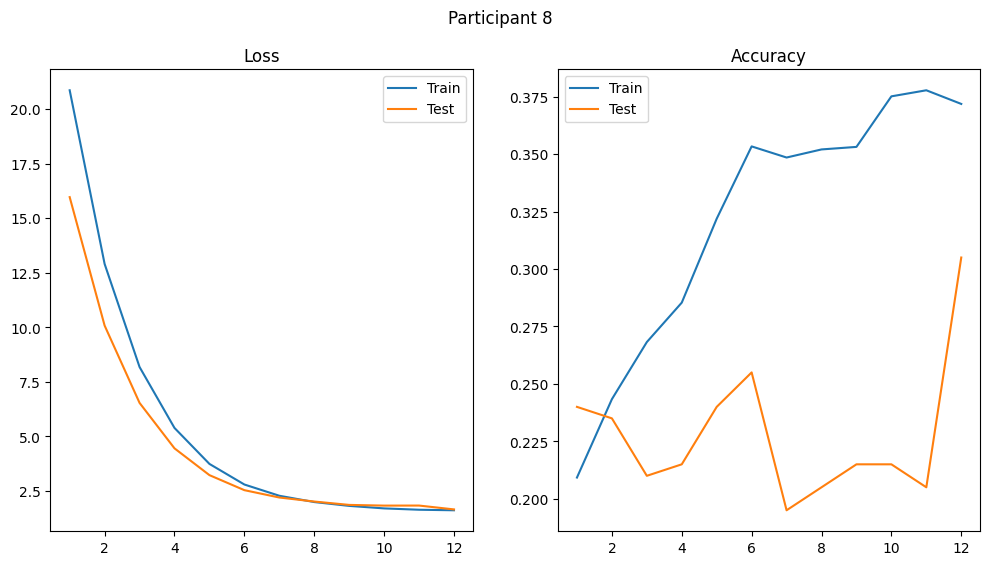

Outer Loop 10 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
      Test index:                                         [13]



Epoch 1/500
69/69 [==============================] - 17s 121ms/step - loss: 21.7728 - accuracy: 0.2075 - val_loss: 16.9283 - val_accuracy: 0.2543
Epoch 2/500
69/69 [==============================] - 7s 103ms/step - loss: 13.7744 - accuracy: 0.2362 - val_loss: 10.8700 - val_accuracy: 0.2171
Epoch 3/500
69/69 [==============================] - 7s 103ms/step - loss: 8.8350 - accuracy: 0.2755 - val_loss: 7.0697 - val_accuracy: 0.2057
Epoch 4/500
69/69 [======

<Figure size 640x480 with 0 Axes>

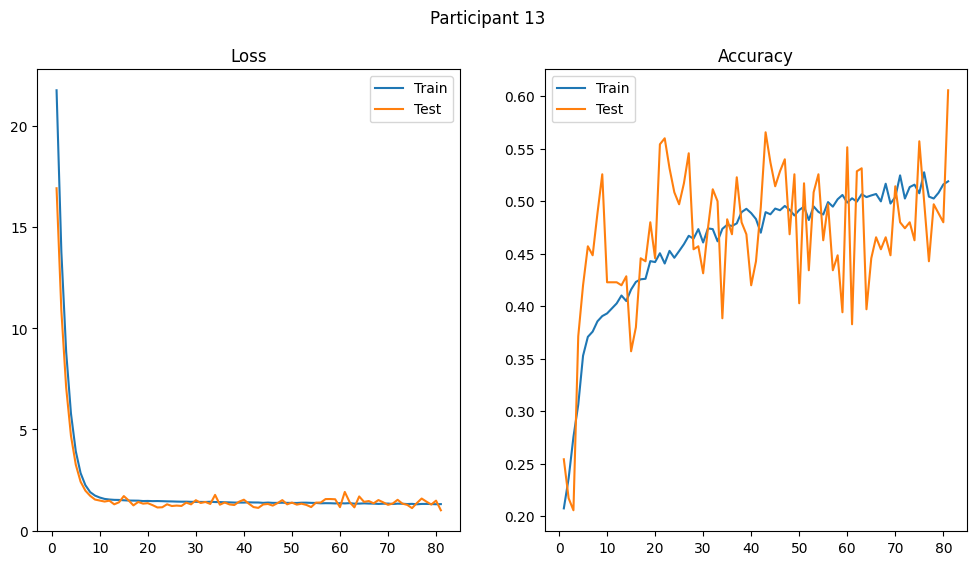

Outer Loop 11 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [3]



Epoch 1/500
69/69 [==============================] - 17s 121ms/step - loss: 20.8135 - accuracy: 0.2212 - val_loss: 16.0680 - val_accuracy: 0.2171
Epoch 2/500
69/69 [==============================] - 7s 103ms/step - loss: 12.9747 - accuracy: 0.2598 - val_loss: 10.2186 - val_accuracy: 0.1886
Epoch 3/500
69/69 [==============================] - 7s 103ms/step - loss: 8.2676 - accuracy: 0.2860 - val_loss: 6.6443 - val_accuracy: 0.1886
Epoch 4/500
69/69 [======

<Figure size 640x480 with 0 Axes>

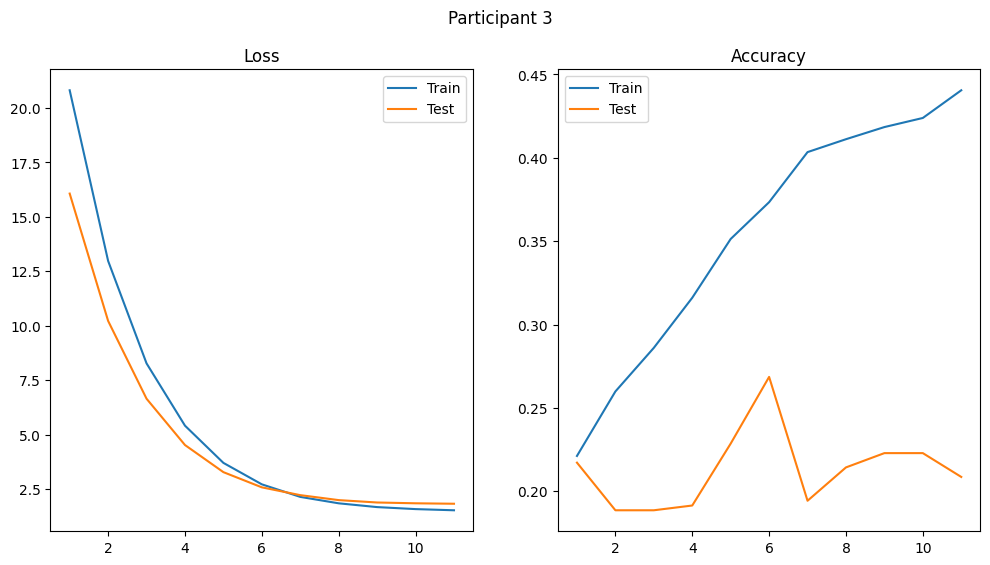

Outer Loop 12 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [7]



Epoch 1/500
69/69 [==============================] - 17s 120ms/step - loss: 21.3147 - accuracy: 0.2187 - val_loss: 16.4533 - val_accuracy: 0.2114
Epoch 2/500
69/69 [==============================] - 7s 102ms/step - loss: 13.3315 - accuracy: 0.2489 - val_loss: 10.4620 - val_accuracy: 0.2914
Epoch 3/500
69/69 [==============================] - 7s 104ms/step - loss: 8.5076 - accuracy: 0.2815 - val_loss: 6.7934 - val_accuracy: 0.2686
Epoch 4/500
69/69 [======

<Figure size 640x480 with 0 Axes>

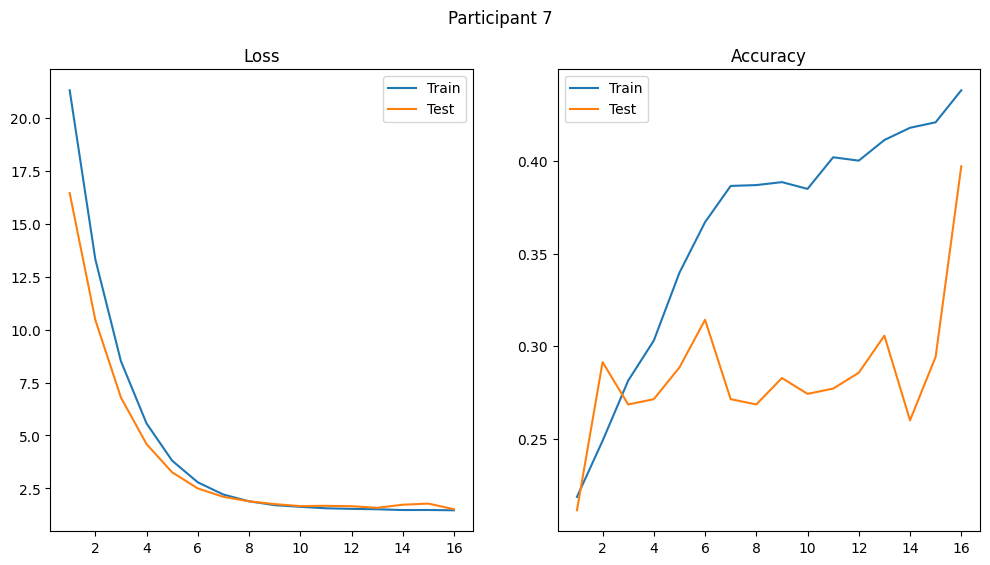

Outer Loop 13 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
      Test index:                                         [14]



Epoch 1/500
69/69 [==============================] - 17s 123ms/step - loss: 19.6782 - accuracy: 0.2205 - val_loss: 15.1626 - val_accuracy: 0.2000
Epoch 2/500
69/69 [==============================] - 7s 104ms/step - loss: 12.2482 - accuracy: 0.2371 - val_loss: 9.6372 - val_accuracy: 0.1657
Epoch 3/500
69/69 [==============================] - 7s 104ms/step - loss: 7.7989 - accuracy: 0.2749 - val_loss: 6.2869 - val_accuracy: 0.1514
Epoch 4/500
69/69 [=======

<Figure size 640x480 with 0 Axes>

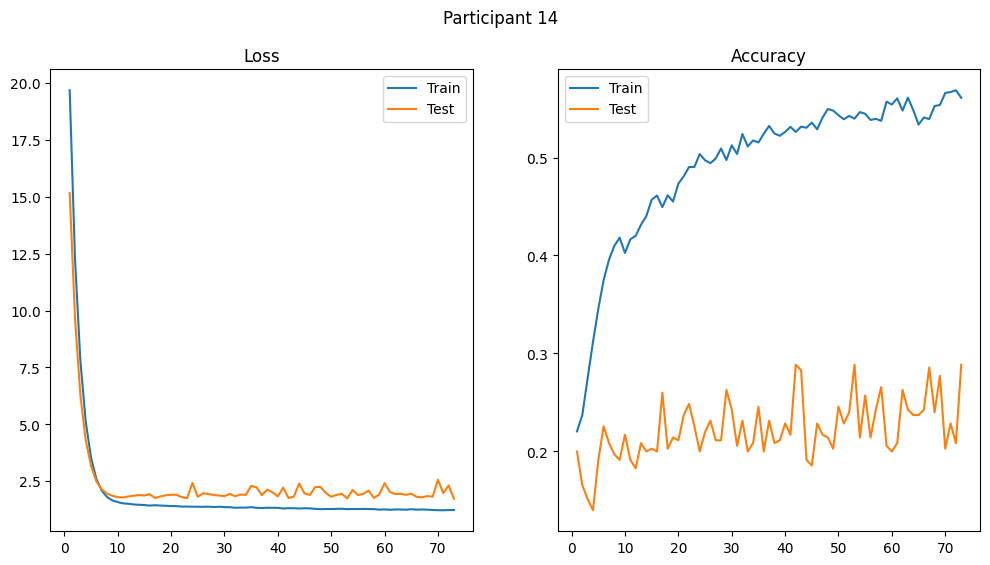

Outer Loop 14 

      Train epochs' shape:                                (4395, 1, 64, 1123)
      Test epochs' shape:                                 (350, 1, 64, 1123)
      Test labels' shape:                                 (350, 5)
      Train labels' shape (without encoding):             (4395, 1)
      Test labels' shape (without encoding):              (350, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14]
      Test index:                                         [9]



Epoch 1/500
69/69 [==============================] - 17s 122ms/step - loss: 20.8096 - accuracy: 0.2134 - val_loss: 16.0458 - val_accuracy: 0.2143
Epoch 2/500
69/69 [==============================] - 7s 105ms/step - loss: 12.9551 - accuracy: 0.2380 - val_loss: 10.1867 - val_accuracy: 0.1800
Epoch 3/500
69/69 [==============================] - 7s 104ms/step - loss: 8.2221 - accuracy: 0.2746 - val_loss: 6.6234 - val_accuracy: 0.2000
Epoch 4/500
69/69 [======

<Figure size 640x480 with 0 Axes>

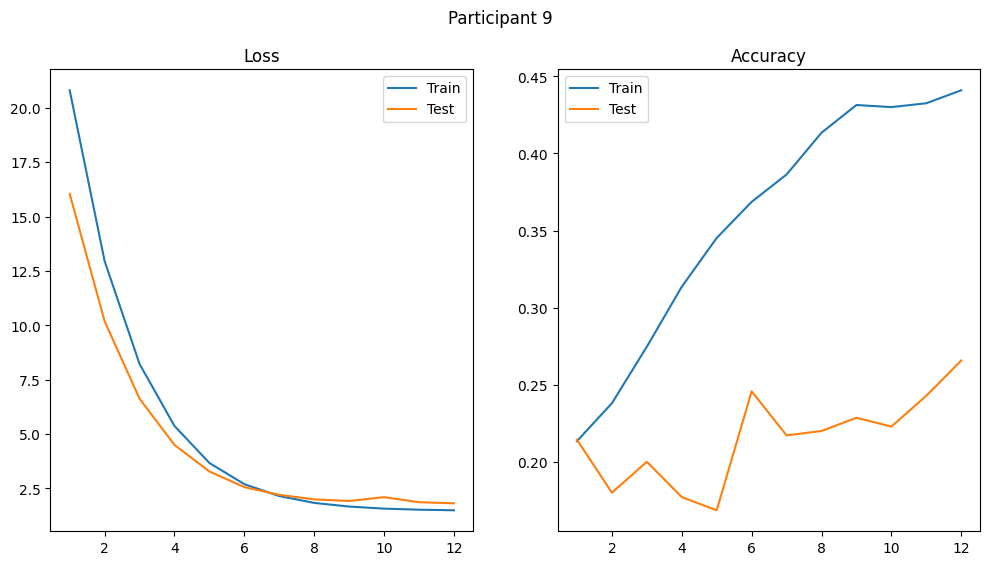

<Figure size 640x480 with 0 Axes>

In [26]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0001



kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    
    dataset = 'BCI2a'
    in_samples = 1123                   # Changed!!!
    n_channels = 64
    n_classes = 5
    
    
    # Set dataset paramters as dataset configuration
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'n_channels': n_channels, 'in_samples': in_samples}


    # Set training hyperparamters as train configuration
    train_conf = { 'batch_size': 64, 'epochs': 1123, 'patience': 50, 'lr': 0.001,
                  'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

    model = getModel(train_conf.get('model'), dataset_conf)
    

    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=train_conf.get('lr')), metrics=['accuracy'])  
    
    
    patience = 50
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    
    
    # Train the model
    history = model.fit(
        train_epochs, train_labels,
        validation_data=(test_epochs, test_labels),
        epochs=max_epochs,
        batch_size=64,  # Adjust as needed
        callbacks=[early_stopping]
    )
    
    y_pred_test = model.predict(test_epochs)
    y_true_test = test_labels
    
    with open("y_pred_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_pred_test, f)
    
    with open("y_true_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_true_test, f)
    
    # Collect training metrics
    train_loss_epochs.extend(history.history['loss'])
    train_acc_epochs.extend(history.history['accuracy'])

    # Collect testing metrics
    test_loss_epochs.extend(history.history['val_loss'])
    test_acc_epochs.extend(history.history['val_accuracy'])
    
    epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:-1*patience])
    plt.plot(epochs_range, test_loss_epochs[:-1*patience])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:-1*patience])
    plt.plot(epochs_range, test_acc_epochs[:-1*patience])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

In [27]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(1, 15):
    with open("y_pred_testID_{}.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_testID_{}.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
        
    y_true = all_y_true[i-1]
    y_pred = all_y_pred[i-1]
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [28]:
len(confusion_matrices)

14

In [29]:
confusion_matrices[8]

array([[25, 36,  0,  1,  8],
       [14, 50,  0,  0,  6],
       [25, 32,  1,  0, 12],
       [13, 38,  0,  2, 17],
       [23, 30,  1,  1, 15]])

In [30]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)', 'Rest (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)', 'Rest (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 5


In [ ]:
summation.sum(axis=1)

In [ ]:
acc

In [31]:
print("Dataset: Phase-1 Hadi (5-Class)")
print("The cross-subject scenario:")
print("Algorithm: ATCNet")
print("Accuracy: ", acc)

normalized

Dataset: Phase-1 Hadi (5-Class)
The cross-subject scenario:
Algorithm: ATCNet
Accuracy:  0.36238872475697


Left (Pred)  Right (Pred)  Feet (Pred)  Tongue (Pred)  \
Left (True)       0.295671      0.261880     0.066526       0.186906   
Right (True)      0.147368      0.515789     0.072632       0.109474   
Feet (True)       0.114858      0.160169     0.128556       0.301370   
Tongue (True)     0.084299      0.163330     0.124341       0.330875   
Rest (True)       0.103158      0.133684     0.064211       0.157895   

               Rest (Pred)  
Left (True)       0.189018  
Right (True)      0.154737  
Feet (True)       0.295047  
Tongue (True)     0.297155  
Rest (True)       0.541053

In [72]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])

4

# Test for the effect of calibration:

In [32]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [49]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [50]:
"{:02}{:02}".format(2, 3)

'0203'

In [51]:
models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [52]:
Calibrated_models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


Outer Loop 1 and Inner Loop 1: 

      Train epochs' shape:                                (1337, 64, 1123)
      Cross-validation epochs' shape:                     (420, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [1, 2, 3, 4, 5, 6, 7, 8, 10, 13]
      Cross-validation index:                            [0, 9, 12]
      Test index:                                        [11]



Train features shape:             (1337, 576)
Cross-validation features shape:  (420, 576)
Test features shape:              (140, 576)
Outer Loop 1 and Inner Loop 2: 

      Train epochs' shape:                                (1477, 64, 1123)
      Cross-validation epochs' shape:                     (280, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13]
      Cross-validation index:      

In [26]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [27]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [28]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

class 1 (Pred)  class 2 (Pred)
class 1 (True)             358             162
class 2 (True)             202             315

In [31]:
summation / 520

class 1 (Pred)  class 2 (Pred)
class 1 (True)        0.688462        0.311538
class 2 (True)        0.388462        0.605769

In [29]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


Average metrics for binary classification (Left vs Right hand):


       Accuracy:                  0.65

       Precision:                 0.66

       Recall (Sensitivity):      0.61     

       F1 Score:                  0.63



# Test of the functions:

In [37]:
a = np.random.rand(200, 4, 22, 250)
b = np.random.randint(0, 3, (200, 1))
c = np.random.rand(50, 4, 22, 250)

In [ ]:
train_features, test_features = feature_extraction_4(a, b, c, sampling_freq=250)

In [43]:
train_features.shape

(800, 80)

In [45]:
test_features.shape

(200, 80)

# Filter validation:

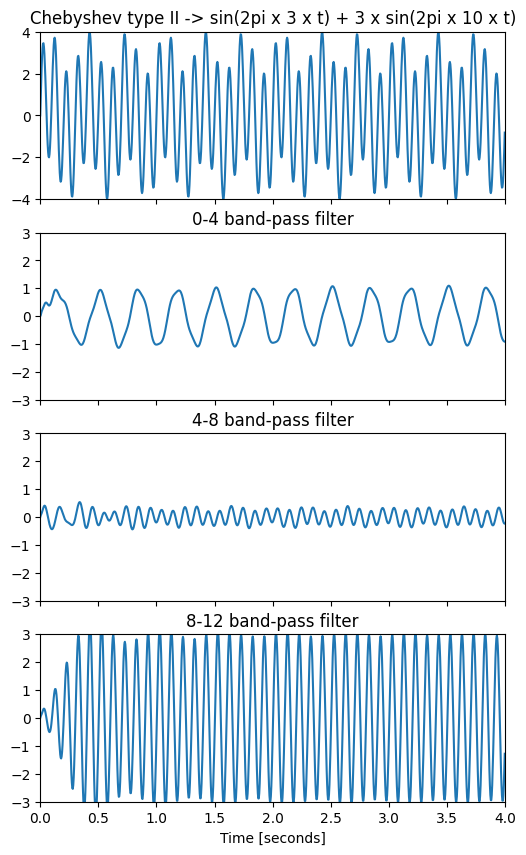

In [85]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
--------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


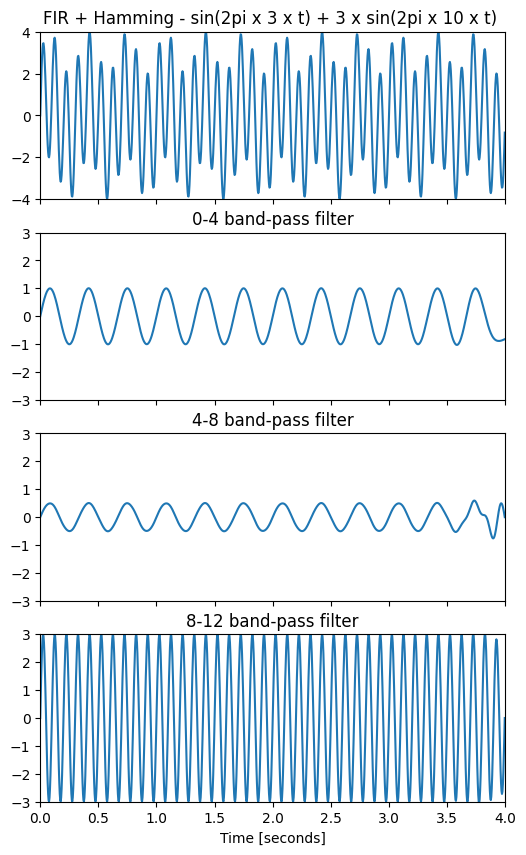

In [86]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('FIR + Hamming - sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t) ')
ax1.axis([0, 1, -4, 4])


filtered = mne.filter.filter_data(sig, 250, 0, 4)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 4, 8)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 8, 12)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (3, 1000)

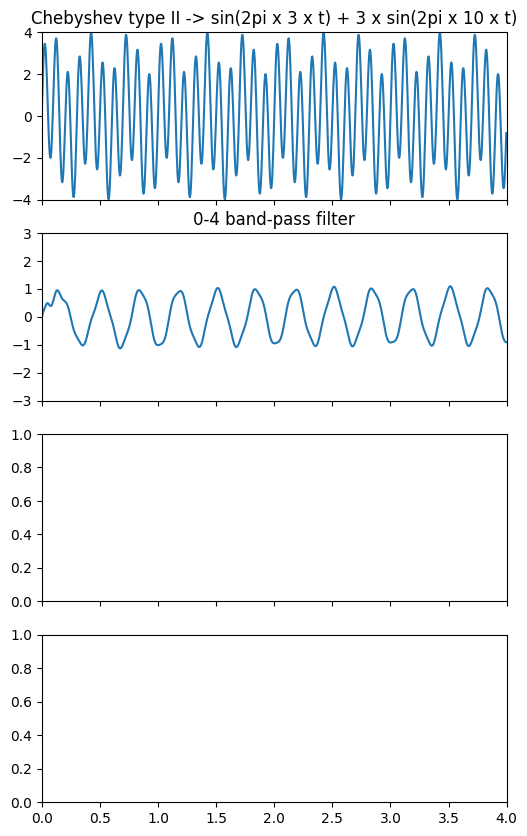

In [29]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)

sig = np.tile(sig, (3, 1))

print(sig.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig[0])
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered[0])
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

# CSP Validation:

In [199]:
t = np.linspace(0, 5, 1250, False)  # 4 second
sig1 = np.sin(2*np.pi*35*t) + 3 * np.sin(2*np.pi*10*t)
sig2 = np.sin(2*np.pi*100*t) + 3 * np.sin(2*np.pi*50*t)

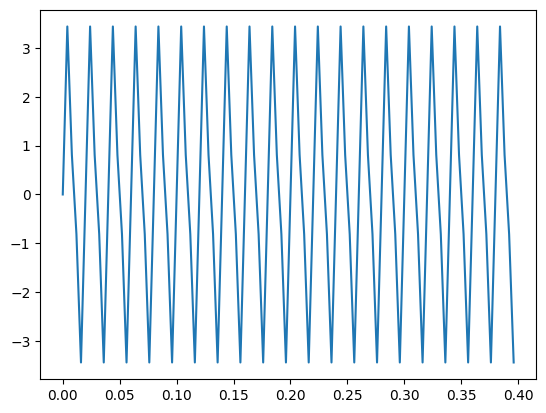

In [200]:
plt.plot(t[:100], sig2[:100])

In [201]:
np.expand_dims(sig1, axis=1)

array([[ 0.        ],
       [ 1.5165829 ],
       [ 2.42754827],
       ...,
       [-2.53539499],
       [-2.42754827],
       [-1.5165829 ]])

In [202]:
sig1 = np.expand_dims(sig1, axis=0)
sig2 = np.expand_dims(sig2, axis=0)
sig1.shape, sig2.shape

((1, 1250), (1, 1250))

In [203]:
sig = np.concatenate((sig1, sig2), axis=0)

In [204]:
sig = np.expand_dims(sig, axis=0)
sig.shape

(1, 2, 1250)

In [205]:
s_epoch = np.tile(sig, (50, 1, 1))
s_epoch.shape, (s_epoch[0, :, :] == s_epoch[10, :, :]).all()

((50, 2, 1250), True)

In [206]:
s_train_epochs = slicer(s_epoch, num_splits=2)

In [207]:
s_train_epochs.shape

(50, 2, 2, 625)

In [208]:
s_no_encoded_train_labels = np.random.randint(0, 3, (50, 1))

In [209]:
mne.set_log_level('warning')
train_feats, test_feats, filtered_data = Preprocess_validator(s_train_epochs, s_no_encoded_train_labels, s_train_epochs, sampling_freq = 250, n_components=2)

The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005878448486328
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011038541793823242
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010999679565429688
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005163192749023
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012004613876342773
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010001897811889648
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012008190155029297
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.009999990463256836
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp ca

In [210]:
train_feats.shape

(50, 2, 16, 2)

In [211]:
filtered_data.shape

(50, 2, 2, 625)

In [212]:
(filtered_data[0, :, :, :] == filtered_data[10, :, :, :]).all()

True

In [213]:
(filtered_data[:, :, 0, :] == filtered_data[:, :, 0, :]).all()

True

In [214]:
(filtered_data[:, 0, :, :] == filtered_data[:, 1, :, :]).any()

True

In [215]:
(s_train_epochs[:, 0, :, :] == s_train_epochs[:, 1, :, :]).any()

False

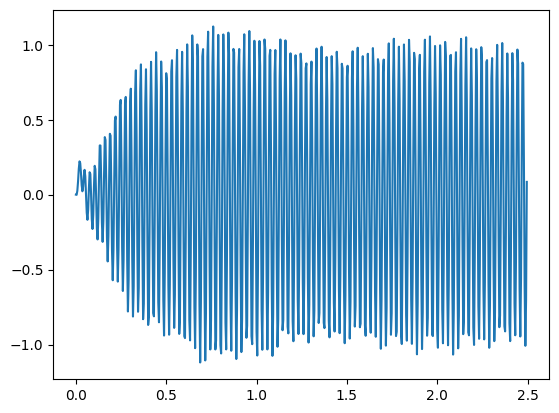

In [216]:
y = filtered_data[0, 1, 0, :]
plt.plot(t[:625], y)

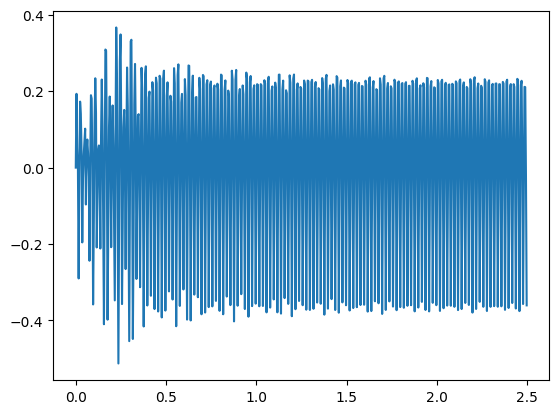

In [217]:
y = filtered_data[0, 0, 1, :]
plt.plot(t[:625], y)

# Heatmap on FBCSP:

In [218]:
with open("train_features_fortestID_[0].pickle", "rb") as f:
    train_features = pickle.load(f)
    f.close()

In [219]:
train_features.shape

(2160, 5, 16, 16)

In [221]:
new_array = np.zeros((2160, 16, 80))

In [222]:
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = train_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)

(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)


In [223]:
new_array.shape

(2160, 16, 80)

In [225]:
heat_value = new_array.mean(axis=0)

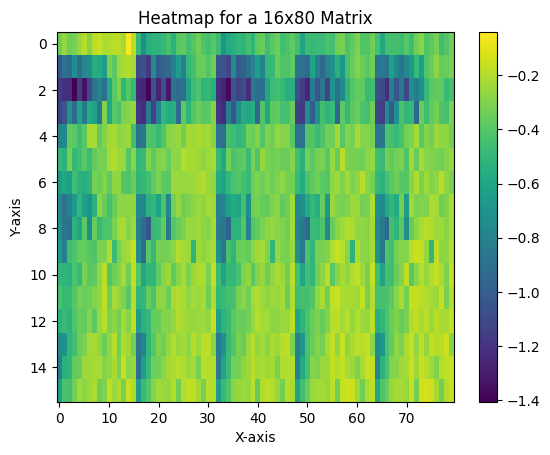

In [226]:
plt.imshow(heat_value, cmap='viridis', aspect='auto')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heatmap for a 16x80 Matrix')

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()

In [29]:
all_epochs = np.concatenate(all_data_epochs)
all_labels = np.concatenate(no_encode)


mne.set_log_level('warning')
all_features, _ = feature_extraction_cheby2(all_epochs, all_labels, all_epochs, sampling_freq = 250, n_components=16)
#sys.stdout.close()
#sys.stdout = original_stdout


print("All epochs features shape:", all_features.shape)


with open("All_data_features.pickle", "wb") as f:
    pickle.dump(all_features, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()


The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.928704977035522
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.971172571182251
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.614934921264648
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.451647520065308
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.614197254180908
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.34934687614441
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.473000526428223
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.482449293136597
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.383591890335083
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.589037895202637
The filtered data shape: (12240, 22, 200)
Time take

NameError: name 'train_features' is not defined

In [47]:
new_array = np.zeros((2448, 16, 80))
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = all_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)
print("\n\n")
print("new array shape:", new_array.shape)

(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)



new array shape: (2448, 16, 80)


In [30]:
print("All epochs features shape:", all_features.shape)

All epochs features shape: (2448, 5, 16, 16)


In [48]:
epochs_1 = new_array[(all_labels == 0).squeeze(), :, :]
epochs_2 = new_array[(all_labels == 1).squeeze(), :, :]
epochs_3 = new_array[(all_labels == 2).squeeze(), :, :]
epochs_4 = new_array[(all_labels == 3).squeeze(), :, :]


In [49]:
print("Left epochs shape:  ", epochs_1.shape)
print("Right epochs shape: ", epochs_2.shape)
print("Feet epochs shape:  ", epochs_3.shape)
print("Tongue epochs shape:", epochs_4.shape)

Left epochs shape:   (648, 16, 80)
Right epochs shape:  (648, 16, 80)
Feet epochs shape:   (576, 16, 80)
Tongue epochs shape: (576, 16, 80)


In [50]:
epochs_1 = epochs_1.mean(axis=0)
epochs_2 = epochs_2.mean(axis=0)
epochs_3 = epochs_3.mean(axis=0)
epochs_4 = epochs_4.mean(axis=0)

In [62]:
epochs_1

(16, 80)

In [34]:
(all_labels == 0).sum()

648

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 800x1000 with 0 Axes>

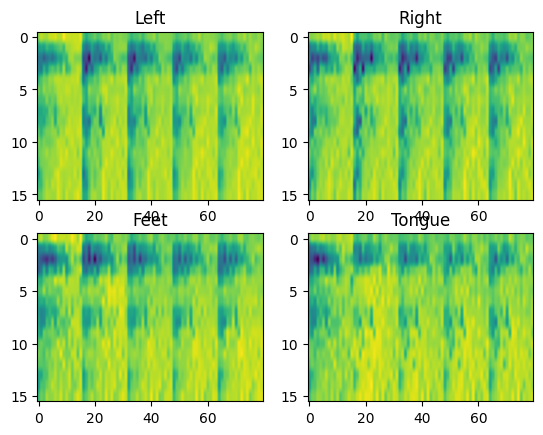

In [59]:
plt.figure(1, (8, 10))
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(epochs_1, cmap='viridis', aspect='auto')
axs[0, 0].set_title("Left")

axs[0, 1].imshow(epochs_2, cmap='viridis', aspect='auto')
axs[0, 1].set_title("Right")

axs[1, 0].imshow(epochs_3, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Feet")

axs[1, 1].imshow(epochs_4, cmap='viridis', aspect='auto')
axs[1, 1].set_title("Tongue")

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()